### Clasificar imágenes con Redes Neuronales Convolucional

### MNIST

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets('/tmp/MNIST_data/', one_hot=True )

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [4]:
mnist.train.images.shape

(55000, 784)

In [5]:
mnist.train.num_examples

55000

In [6]:
mnist.test.num_examples

10000

In [7]:
mnist.validation.num_examples

5000

### Visualización del dataset

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

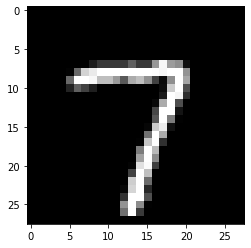

In [9]:
plt.imshow( mnist.train.images[100].reshape(28, 28), cmap='gist_gray' )

In [10]:
mnist.train.images[100].min()

0.0

In [11]:
mnist.train.images[100].max()

0.9960785

### Codificación **onehot**

In [12]:
mnist.train.labels[100]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

## Arquitectura

## Funciones *helper*

Función para inicializar pesos

In [13]:
def init_weigths(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

Función para inicializar bias:

In [14]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

* Convolución:

x: Entrada. [batch, in_height, in_width, in_channels]

W: Filtro.  [filter_height, filter_width, in_channels, out_channels]

In [15]:
def conv2d(x, W, stride):
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='SAME')

* Max Pooling

In [16]:
def max_pool(x, size):
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], strides=[1, size, size, 1], padding='SAME')

* Capa convolucional

input_x: Imagen de entrada

shape: [filter_height, filter_width, in_channels, out_channels]

In [17]:
def convolutional_layer(input_x, shape):
    W = init_weigths(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(x=input_x, W=W, stride=1) + b)

* Capa *fully connected*

input_x: datos d entrada

size: # de neuronas de la capa

In [18]:
def fully_connected_layer(input_x, size):
    input_size = int(input_x.get_shape()[1])
    W = init_weigths([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_x, W) + b

### Placeholders

In [19]:
x = tf.placeholder(tf.float32, shape=[None, 784])

In [20]:
y_true = tf.placeholder(tf.float32, shape=[None, 10])

## Arquitectura

In [21]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [22]:
x_image

<tf.Tensor 'Reshape:0' shape=(?, 28, 28, 1) dtype=float32>

* Primera convolución y pooling

In [23]:
conv_1 = convolutional_layer(x_image, shape=[7, 7, 1, 32])
conv_1_pool = max_pool(conv_1, 2)

In [24]:
conv_1

<tf.Tensor 'Relu:0' shape=(?, 28, 28, 32) dtype=float32>

In [25]:
conv_1_pool

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 32) dtype=float32>

* Segunda convolución y pooling

In [26]:
conv_2 = convolutional_layer(conv_1_pool, [7, 7, 32, 64])
conv_2_pool = max_pool(conv_2, 2)

In [27]:
conv_2

<tf.Tensor 'Relu_1:0' shape=(?, 14, 14, 64) dtype=float32>

In [28]:
conv_2_pool

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 64) dtype=float32>

* Fully Connected

In [29]:
conv_2_flat = tf.reshape(conv_2_pool, [-1, 7*7*64])

In [30]:
conv_2_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 3136) dtype=float32>

In [31]:
full_1 = tf.nn.sigmoid(fully_connected_layer(conv_2_flat, 1024))

In [32]:
full_1

<tf.Tensor 'Sigmoid:0' shape=(?, 1024) dtype=float32>

In [33]:
y_pred = tf.nn.sigmoid( fully_connected_layer(full_1, 10) )

## Pérdida

In [34]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Optimizador

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.00002)
train = optimizer.minimize(loss)

## Métricas

In [36]:
matches = tf.equal( tf.argmax(y_true,1), tf.argmax(y_pred,1) )
acc = tf.reduce_mean( tf.cast(matches, tf.float32) )

Inicializar variables

In [37]:
init = tf.global_variables_initializer()

## Session

In [38]:
episodes = 2000
batch_size = 50

losses_train = []
losses_test_ep = []
losses_test = []
accs_test = []

sess = tf.InteractiveSession()

sess.run(init)
for ep in range(episodes):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    feed_dict = {x:batch_x, y_true:batch_y}
    _, loss_ep_train = sess.run([train, loss], feed_dict=feed_dict)
    losses_train.append(loss_ep_train)
    if ep%200==0:
        feed_dict = {x:mnist.test.images, y_true:mnist.test.labels}
        loss_ep_test, acc_ep_test = sess.run([loss, acc], feed_dict=feed_dict)
        losses_test.append(loss_ep_test)
        losses_test_ep.append(ep)
        accs_test.append(acc_ep_test)
        print(f'episode:{ep}')
        # print(f'episode:{ep}, train_loss:{loss_ep_train}, test_loss:{loss_ep_test}, test_acc:{acc_ep_test}')

episode:0
episode:200
episode:400
episode:600
episode:800
episode:1000
episode:1200
episode:1400
episode:1600
episode:1800


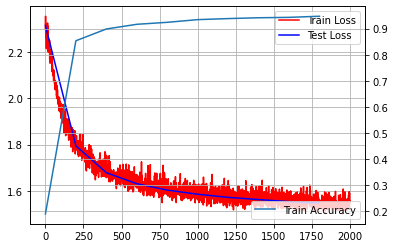

In [39]:
fig, ax1 = plt.subplots()

ax1.plot(losses_train, color='r', label='Train Loss')
ax1.plot(losses_test_ep, losses_test, color='b', label='Test Loss')
ax1.legend()
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(losses_test_ep, accs_test, label='Train Accuracy')
ax2.legend()
ax2.grid()

plt.show()

## Nueva Imagen

In [48]:
idx_test = 190

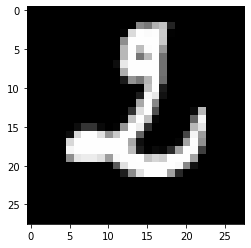

In [49]:
plt.imshow( mnist.validation.images[idx_test].reshape(28, 28), cmap='gist_gray' )

In [50]:
feed_dict = { x:[mnist.validation.images[idx_test]] }
new_image_pred = sess.run(y_pred, feed_dict=feed_dict)

In [51]:
np.argmax(new_image_pred)

2